<a href="https://colab.research.google.com/github/marioskyriacou/Bipartite_Graphs_Manual/blob/main/Simulate_Inference_Bipartite_Network_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Installations
!pip install numpyro
!pip install funsor

In [2]:
# Main Libraries
import pandas as pd
import numpy as np
import numpyro
import os
import jax
import time
import pickle
import networkx as nx
import matplotlib
import seaborn as sns
import scipy.io

print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Numpyro: {numpyro.__version__}')
print(f'Networkx: {nx.__version__}')
print(f'Jax: {jax.__version__} // Jax Devices:{jax.devices()[0]}')
print(f'Pickle: {pickle.format_version}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')

Pandas: 2.2.2
Numpy: 1.26.4
Numpyro: 0.15.3
Networkx: 3.4.2
Jax: 0.4.33 // Jax Devices:TFRT_CPU_0
Pickle: 4.0
Matplotlib: 3.8.0
Seaborn: 0.13.2


In [3]:
# Visualization
import matplotlib.pyplot as plt

# Jax
from jax import numpy as jnp
from jax import random as jrandom
from jax import vmap
import jax.scipy.special as special
import jax.random as random


# NumpyRO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.infer import (
    MCMC,
    HMC,
    MixedHMC,
    init_to_value,
    NUTS,
    DiscreteHMCGibbs)
from numpyro.infer import Predictive
from numpyro.distributions import constraints

## Generate a graph from the prior model
from jax import random as random_jx
from jax import lax, jit, ops
from numpyro.infer import Predictive

# table creation
from tabulate import tabulate

#mount the drive so that I can read and write on files on my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper Classes

In [4]:
# I create the etBFRY function by making a class
class etBFRY(numpyro.distributions.Distribution):
    arg_constraints = {
        # "sigma": constraints.unit_interval,
        # "alpha": constraints.positive,
        "tau": constraints.positive
    }
    support = constraints.positive
    reparametrized_params = ["sigma", "alpha", "tau"]

    def __init__(self, L, alpha, sigma, tau):
        #read parameters
        self.L = L
        self.sigma = sigma
        self.tau = tau
        self.alpha = alpha
        self.t_as = (self.sigma*self.L/self.alpha)**(1.0/self.sigma)
        super().__init__(batch_shape = (1, self.L), event_shape=())

    def sample(self, key, sample_shape=()):
        #generate from the distribution
        shape = sample_shape + self.batch_shape
        G_dist = dist.Gamma(1.0-self.sigma, 1.0)
        G = G_dist.sample(key,shape) if isinstance(self.sigma, float) else G_dist.sample(key,(1,))
        U_dist = dist.Uniform()
        U = U_dist.sample(key,shape)
        R = G*((1.0-U)*(self.t_as+self.tau)**self.sigma + U*self.tau**self.sigma)**(-1.0/self.sigma)
        return R

    def log_prob(self, value):
      #evaluate the log probability density
      # return jnp.log(self.sigma)+(-1-self.sigma)*jnp.log(value)-self.tau*value+jnp.log(1-jnp.exp(-value*self.t_as))-special.gammaln(1-self.sigma)-jnp.log((self.tau+self.t_as)**self.sigma-self.tau**self.sigma)
      return jnp.log(self.sigma / ((self.tau+self.t_as)**self.sigma-self.tau**self.sigma))+(-1-self.sigma)*jnp.log(value)-self.tau*value+jnp.log(1-jnp.exp(-value*self.t_as))-special.gammaln(1-self.sigma)



In [5]:
class check_values():
  def __init__(self, rng_key):
    self.rng_key = rng_key

  def check_alpha(self, alpha, value_name):
    #create a smaple from the below distribution , if a value is not given
    # Distributions: dist.HalfNormal(20) (mean=talpha*1.25=30*1.25 ~37) (var = (1-2pi)scale*2) //  dist.HalfCauchy(20) // dist.Gamma(90,3)
    if alpha is None:return numpyro.sample(str(value_name), dist.HalfNormal(20), rng_key= self.rng_key)
    else: return numpyro.deterministic(str(value_name),alpha) # if given a value


  def check_sigma(self, sigma, value_name):
    #create a smaple from the below distribution , if a value is not given
    # Distributions:  dist.HalfNormal(1) 1 - sigma ~ Improper Unif //  dist.Uniform(0,1) //  TruncatedDistribution(dist.Normal(1,1), low=0, high=1) //
    # truncated_normal_model(num_observations, high=1, x=None) //  TruncatedNormal(loc=1, scale=1,low=0, high=1) //  dist.TruncatedDistribution(dist.Normal(0.5, 1), low=0.01, high=2)
    if sigma is None:return  numpyro.sample( str(value_name), dist.Beta(2,10), rng_key= self.rng_key) # (1/9, 1) (1,4)
    else: return  numpyro.deterministic(str(value_name), sigma)


  def check_tau(self, tau, value_name):
     #create a smaple from the below distribution , if a value is not given
      if tau is None:return numpyro.sample(str(value_name), dist.HalfNormal(1), rng_key= self.rng_key)
      else: return numpyro.deterministic(str(value_name),tau)

  def check_a(self, a, p, value_name):
    if a is None:return numpyro.sample( str(value_name), dist.HalfNormal(2), sample_shape=(p, ), rng_key= self.rng_key)
    else:return numpyro.deterministic(str(value_name), a)

  def check_b(self, b, p, value_name):
    # b = numpyro.sample("b", dist.Gamma(0.01, 0.01), sample_shape=(p,))
    if b is None:return numpyro.sample( str(value_name), dist.HalfNormal(2), sample_shape=(p, ), rng_key= self.rng_key)
    else: return numpyro.deterministic(str(value_name), b)

  def affiliation_scores(self, scores, W, alpha, sigma, tau, a, b, nodes, scores_name, w_name):
    if scores is None:
        # Ditributions: dist.Beta(a, b), sample_shape=(L,p) // dist.Gamma(a, b), sample_shape=(L, p) // dist.HalfNormal(4), sample_shape=(L,)
        scores = numpyro.sample(str(scores_name), dist.Gamma(a, b), sample_shape=(nodes, ), rng_key= self.rng_key) # if a, b vectors
    else:
        scores = numpyro.deterministic(str(scores_name), scores)

    if W is None:
      W = numpyro.sample(str(w_name), etBFRY(nodes, alpha, sigma, tau), rng_key= self.rng_key)
      W = W.reshape(nodes,)
    else:
      W = numpyro.deterministic(str(w_name), W)

    return scores, W

# Network Details

In [6]:
class Network_details():

  def add_zeros(adj_matrix, ratio=1.1):
      # add zeros to the adj matrix based on a given ratio
      print(f'Adj matrix: {adj_matrix.shape} ')
      # Dimenshion Shapes
      L_upper, L_lower = adj_matrix.shape[0], adj_matrix.shape[1]
      # Dimenshion new shapes
      L_upper_new, L_lower_new = int(L_upper * ratio), int(L_lower * ratio) # ratio of update shape 1.5
      # new matrix
      matrix_new = np.zeros((L_upper_new, L_lower_new))
      matrix_new[0:L_upper, 0:L_lower]  = np.array(adj_matrix)
      print(f'New Adj matrix: {matrix_new.shape} ')
      return matrix_new, L_upper_new, L_lower_new

  def network_statistics(typeA_nodes, typeB_nodes, adj_matrix):
      # main Vairbles
      num_edges = np.sum(adj_matrix)

      #Statistics
      top_average = num_edges / typeA_nodes
      bottom_average = num_edges / typeB_nodes
      graph_average  = (2*num_edges) / (top_average + bottom_average)
      density = num_edges / (typeB_nodes * typeA_nodes)
      sparsity = num_edges / (typeB_nodes + typeA_nodes)**2

      # Prepare data for tabulation
      table_data = [
          ['# Top Nodes', typeB_nodes],
          ['# Bottom Nodes', typeA_nodes],
          ['# Edges', num_edges],
          ['Top average degree ', round(top_average, 4)],
          ['Bottom Average degree', round(bottom_average, 4)],
          ['Graph Average degree', round(graph_average, 4)],
          ['Density', round(density, 4)],
          ['Sparsity', round(sparsity, 4)]]

      print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='grid'))

  def plt_deg_distr(deg, title, binned=False):
    # Plot Degree Distributions:
    # Count the degrees of each nodes for one type of nodes (A or B) -> eliminate the 0 connections
    # plot the degree distribution
    deg = deg[deg > 0]
    num_nodes = len(deg)
    freq = pd.Series(deg).value_counts().to_dict()  # Count the occurrences of each degree

    if binned == True:
        freq = [x / num_nodes for x in list(freq.values())] ## Normalize frequency values
        bins = np.exp(np.linspace(np.log(min(freq)), np.log(max(freq)), 20)) #logarithmic bins for frequency values
        sizebins = (bins[1:] - bins[:-1]) #width of each bin
        # sizebins = np.append(sizebins, 1)
        counts = np.histogram(freq, bins=bins)[0]
        freq = counts/sizebins #Normalize counts by bin size
        freq = freq/sum(freq) #Further normalize frequency so the total sums to 1

        plt.figure()
        plt.plot(bins[:-1], freq, 'bo', label='empirical')
        plt.legend()
    else:
        plt.figure()
        plt.plot(list(freq.keys()), [np.exp(np.log(x) - np.log(num_nodes)) for x in list(freq.values())], 'bo', label='deg nodes')
        plt.legend()

    plt.title(f'{title} Degree Distribuiton')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('deg')
    plt.ylabel('frequency')

# et-BFRY Model

In [7]:
def Bipartite_Network_Model(arguments):
    L, L_prime = arguments['L'], arguments['L_prime']
    p = arguments['p']

    #hyperparameters of the BFRY upper & bottom
    talpha, talpha_prime = arguments['alpha'], arguments['alpha_prime']
    tsigma, tsigma_prime = arguments['sigma'], arguments['sigma_prime']
    ttau, ttau_prime = arguments['tau'], arguments['tau_prime']
    wi0, wj0 = arguments['wi0'], arguments['wj0']

   #levels of affiliations to communities
    ta, ta_prime = arguments['a'], arguments['a_prime']
    tb, tb_prime = arguments['b'], arguments['b_prime']
    scores, scores_prime = arguments['scores'], arguments['scores_prime']

    # Adj Matrix
    Z_obs = arguments['Z_obs']
    ###########################################################################
    # Check parameters
    rng_key, rng_key_predict = random_jx.split(random_jx.PRNGKey(2))
    check = check_values(rng_key_predict)
    tau, tau_prime = check.check_tau(ttau, 'tau'), check.check_tau(ttau_prime, 'tau_prime')
    sigma, sigma_prime = check.check_sigma(tsigma, 'sigma'), check.check_sigma(tsigma_prime, 'sigma_prime')
    alpha, alpha_prime = check.check_alpha(talpha, 'alpha'), check.check_alpha(talpha_prime, 'alpha_prime')
    a, a_prime = check.check_a(ta, p, 'a'), check.check_a(ta_prime, p, 'a_prime')
    b, b_prime = check.check_b(tb, p, 'b'), check.check_b(tb_prime, p, 'b_prime')

    print(f'Upper hyperparameters:\n tau:{tau}, sigma:{sigma}, alpha:{alpha}, a:{a}, b:{b}')
    print(f'Bottom hyperparameters:\n tau:{tau_prime}, sigma:{sigma_prime}, alpha:{alpha_prime}, a:{a_prime}, b:{b_prime}')

    ######################## Affiliation Scorres for Upper Nodes & Wi0 ########################
    scores, wi0 = check.affiliation_scores(scores=scores, W=wi0,
                                                     alpha=alpha, sigma=sigma, tau=tau,
                                                     a=a, b=b, nodes=L,
                                                     scores_name='scores', w_name='wi0')
    ###################### Affiliation Scorres for Lower Nodes & Wj0 ##########################
    scores_prime, wj0 = check.affiliation_scores(scores=scores_prime, W=wj0,
                                                     alpha=alpha_prime, sigma=sigma_prime, tau=tau_prime,
                                                     a=a_prime, b=b_prime, nodes=L_prime,
                                                     scores_name='scores_prime', w_name='wj0')

    print(f'Scores: {scores.shape} Wi0:{wi0.shape}\nScores_prieme:{scores_prime.shape} Wj0:{wj0.shape}')

    ############################## Simulate the adj matrix #################################
    Wi = jnp.transpose(jnp.multiply(jnp.transpose(scores), wi0))
    Wj = jnp.transpose(jnp.multiply(jnp.transpose(scores_prime), wj0))
    W_adj = jnp.matmul(Wi, jnp.transpose(Wj))## (L,T,p) x (L_prime,T,p)

    #numpyro.sample("N_obs", dist.Poisson(ww), obs=N_obs)
    numpyro.sample("Z_obs", dist.Bernoulli(1-jnp.exp(-2*W_adj)), obs=Z_obs)

# Simulate Bipartite Network

In [8]:
class Simulate_Bipartite_Network():
  def __init__(self, args):
    self.args = args
    print(f'Arguments Parameters:\n{self.args.items()}')
    self.L, self.L_prime = self.args['L'], self.args['L_prime']
    self.p = self.args['p']

    # hyperparameters of the BFRY upper & bottom
    self.talpha, self.talpha_prime = self.args['alpha'], self.args['alpha_prime']
    self.tsigma, self.tsigma_prime = self.args['sigma'], self.args['sigma_prime']
    self.ttau, self.ttau_prime = self.args['tau'], self.args['tau_prime']
    self.wi0, self.wj0 = self.args['wi0'], self.args['wj0']

   #levels of affiliations to communities
    self.ta, self.ta_prime = self.args['a'], self.args['a_prime']
    self.tb, self.tb_prime = self.args['b'], self.args['b_prime']
    self.scores, self.scores_prime = self.args['scores'], self.args['scores_prime']
    # adjacency matrix
    self.Z_obs = self.args['Z_obs']

    # key used for samples with jax
    self.rng_key, self.rng_key_predict = random_jx.split(random_jx.PRNGKey(22))


  def update_args_dict(self):
    # update the arguments dictonary with the new values
    self.args['Z_obs'] = self.adj_matrix
    self.args['scores'] =  self.Bipartite_graph_draws['scores']
    self.args['scores_prime'] =  self.Bipartite_graph_draws['scores_prime']
    self.args['wi0'] = self.Bipartite_graph_draws['wi0']
    self.args['wj0'] = self.Bipartite_graph_draws['wj0']

  def simulate_bipartite_network(self):
    # Draw bipartite graph
    Bipartite_graph_predictive = Predictive(Bipartite_Network_Model, num_samples=self.args["batch_size"])
    self.Bipartite_graph_draws = Bipartite_graph_predictive(self.rng_key_predict, arguments=self.args)
    self.adj_matrix = self.Bipartite_graph_draws['Z_obs'][0] # get adj matrix

  ######### Return Functions ##########
  def get_update_args(self):
    return self.args

  def get_draws(self):
    return  self.Bipartite_graph_draws
 #####################################

# Infer Bipartite Network

## MCMC Traces and Histogram Plots

**MCMC INFER TRACES PLOTS**

In [9]:
def Plot_MCMC_Traces(mcmc_samples, arguments):
    # Plot the trace plots for MCMC samples of specified parameters
    # Variables needed/ # Calculate the number of iterations for each parameter
    num_chains = arguments['num_chains']
    iters = int(mcmc_samples['wi0'].shape[0] / num_chains)
    iters_prime = int(mcmc_samples['wj0'].shape[0] / num_chains)

    # Identify the parameters that need to be plot
    parameters_list = ['alpha', 'sigma', 'tau', 'a', 'b', 'alpha_prime', 'sigma_prime', 'tau_prime', 'a_prime', 'b_prime']
    plt_params = [key for key, value in arguments.items() if arguments[key] is None and key in parameters_list]

    # Plot each parameter in a graph
    for param in plt_params:
      ## Check if the parameter has multiple subplots
      if len(mcmc_samples[param].shape) > 1:
        num_subplots = mcmc_samples[param].shape[1]
        fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))
        axes = np.array(axes).flatten()
        for i in range(num_subplots):
            for j in range(num_chains):
              #Plot the MCMC trace for each chain
              axes[i].plot(np.arange(iters), mcmc_samples[param][:, i][j*iters_prime:(j+1)*iters_prime], 'o-', alpha = 0.8,  label=f'{param}[{i}]')
              #plt.plot(np.arange(iters), samples[param][i*iters:(i+1)*iters], 'o-')
            axes[i].set_title(f'{param}[{i}]')
      else:
        #For single-dimensional parameters, create a new figure
        plt.figure()
        for i in range(num_chains):
          plt.plot(np.arange(iters_prime), mcmc_samples[param][i*iters_prime:(i+1)*iters_prime], 'o-', alpha = 0.8)
        #plt.axhline(y=np.mean(args[param]), color='red')
        plt.title(param)

**MCMC INFER HISTOGRAM PLOTS**

In [10]:
def Plot_MCMC_Histograms(mcmc_samples, arguments):
    # Plot the trace plots for MCMC samples of specified parameters
    # Variables needed/ # Calculate the number of iterations for each parameter

    # Varibles
    num_bins=20
    num_chains=arguments['num_chains']
    iters = int(mcmc_samples['wi0'].shape[0] / num_chains)
    iters_prime = int(mcmc_samples['wj0'].shape[0] / num_chains)

    # Identify the parameters that need to be plot
    parameters_list = ['alpha', 'sigma', 'tau', 'a', 'b', 'alpha_prime', 'sigma_prime', 'tau_prime', 'a_prime', 'b_prime']
    plt_params = [key for key, value in arguments.items() if arguments[key] is None and key in parameters_list]

    # Plot each parameter in a graph
    for param in plt_params:
      if len(mcmc_samples[param].shape) > 1:
        num_subplots = mcmc_samples[param].shape[1]
        fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))
        axes = np.array(axes).flatten()
        for i in range(num_subplots):
            for j in range(num_chains):
               #Plot the MCMC histogram  for each chain
              axes[i].hist(mcmc_samples[param][:, i][j*iters_prime:(j+1)*iters_prime], num_bins, alpha = 0.5, label=f'{param}[{i}]')
            axes[i].set_title(f'{param}[{i}]')
      else:
        plt.figure()
        for i in range(num_chains):
          #For single-dimensional parameters, create a new figure
          plt.hist(mcmc_samples[param][i*iters:(i+1)*iters], num_bins, alpha = 0.8, label = str(param) )
        #plt.axvline(x=np.mean(args[param]), color='red')
        plt.title(param)

## INFER CLASS

In [11]:
class Infer_Bipartite_Network():

  def __init__(self, infer_args):
    self.infer_args = infer_args
    item_key_lst  = [(i, j) for i, j  in self.infer_args.items()]
    print(item_key_lst)

    # adjacency matrix
    self.Z_obs = self.infer_args['Z_obs']
    # Infer Parameters
    self.num_samples = self.infer_args['num_samples']
    self.num_chains = self.infer_args['num_chains']
    self.thinning = self.infer_args['thinning']

    # key used for samples with jax
    self.rng_key, self.rng_key_predict = random_jx.split(random_jx.PRNGKey(2))

  #################### INFER NETWORK #########################
  def infer_network(self, num_warmup=100):
    kernel = NUTS(Bipartite_Network_Model)
    mcmc = MCMC(kernel,
              num_warmup = num_warmup,
              num_samples = self.num_samples,
              num_chains = self.num_chains,
              thinning = self.thinning)
    mcmc.run(self.rng_key_predict, arguments=self.infer_args)
    mcmc.print_summary()
    self.samples = mcmc.get_samples()

  def get_samples(self):
    return self.samples

  def Plot_Traces(self):
    Plot_MCMC_Traces(mcmc_samples=self.samples, arguments=self.infer_args)

  def Plot_Histograms(self):
    Plot_MCMC_Histograms(mcmc_samples=self.samples, arguments=self.infer_args)

## INFER-SIMULATION PLOTS

**POSTERIOR (LOG) DISTRIBUTION**

In [12]:
def Posterior_distribution(samples_vals, original_val, num_samples, thinning, num_chains, L, L_prime):
  # Plot the posterior distribution for the top m nodes based on estimated weights wi0 and wj0.
  tgraph_index = 1
  m = 50 ## Number of top nodes to plot

  # Extract true and estimated values for Wi0
  Wi0 = original_val['wi0']
  wi0_est = samples_vals['wi0']
  # Reshape and calculate the 95% highest posterior density interval (HPDI) for Wi0
  wi0_est = wi0_est.reshape(int(num_samples/thinning*num_chains), L)
  wi0_est = hpdi(wi0_est, prob=0.95)

 # Extract true and estimated values for Wj0
  Wj0 = original_val['wj0']
  wj0_est = samples_vals['wj0']
  # Reshape and calculate the 95% highest posterior density interval (HPDI) for Wi0
  wj0_est = wj0_est.reshape(int(num_samples/thinning*num_chains), L_prime)
  wj0_est = hpdi(wj0_est, prob=0.95)

  print(f'Wi0 Shape:{wi0_est.shape}\nWj0 Shape:{wj0_est.shape}')

  #indices of the top m nodes by sorting Wi0 in decreasing order
  ind_max_wi0 = np.argsort(-Wi0[tgraph_index, 0, :])[:m] #[tgraph_index, 0, :]
  w0i_ci_max = wi0_est[:, ind_max_wi0]

  #indices of the top m nodes by sorting Wj0 in decreasing order
  ind_max_wj0 = np.argsort(-Wj0[tgraph_index, 0, :])[:m] #
  w0j_ci_max = wj0_est[:, ind_max_wj0]

  #x-axis for each node index and y-axis for confidence intervals
  x = [(i, i) for i in range(m)]
  y = [(w0i_ci_max[0, i], w0i_ci_max[1, i]) for i in range(m)]
  y_prime = [(w0j_ci_max[0, i], w0j_ci_max[1, i]) for i in range(m)]

  #Plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Upper Nodes
  for i, j in zip(x, y):
      ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue')
      ax1.scatter(i[0], Wi0[tgraph_index, 0, ind_max_wi0[i[0]]], color='red')

  ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax1.scatter(i[0], Wi0[tgraph_index, 0, ind_max_wi0[i[0]]], color='red', label='true')
  ax1.title.set_text('Upper Nodes')
  ax1.set_xlabel('index of nodes sorted by decreasing wi0')
  ax1.set_ylabel('wi0')

  # Lower Nodes
  for i, j in zip(x, y_prime):
      ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue')
      ax2.scatter(i[0], Wj0[tgraph_index, 0, ind_max_wj0[i[0]]], color='red')

  ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax2.scatter(i[0], Wj0[tgraph_index, 0, ind_max_wj0[i[0]]], color='red', label='true')
  ax2.title.set_text('Lower Nodes')
  ax2.set_xlabel('index of nodes sorted by decreasing wj0')
  ax2.set_ylabel('wj0')

  fig.tight_layout()
  plt.show()


In [13]:
def Posterior_distribution_Log(samples_vals, original_val, num_samples, thinning, num_chains, L, L_prime):

  tgraph_index = 1
  m = 50
  # Wi0 estimates
  Wi0 = original_val['wi0']
  wi0_est = samples_vals['wi0']
  wi0_est = wi0_est.reshape(int(num_samples/thinning*num_chains), L)
  wi0_est = hpdi(wi0_est, prob=0.95)

  # Wj0 estimates
  Wj0 = original_val['wj0']
  wj0_est = samples_vals['wj0']
  wj0_est = wj0_est.reshape(int(num_samples/thinning*num_chains), L_prime)
  wj0_est = hpdi(wj0_est, prob=0.95)
  print(f'Wi0 Shape:{wi0_est.shape}\nWj0 Shape:{wj0_est.shape}')

  ind_min_wi0 = np.argsort(Wi0[tgraph_index, 0, :])[:m]
  w0i_ci_min = wi0_est[:, ind_min_wi0]

  ind_min_wj0 = np.argsort(Wj0[tgraph_index, 0, :])[:m]
  w0j_ci_min = wj0_est[:, ind_min_wj0]

  x = [(i, i) for i in range(m)]
  y = [(w0i_ci_min[0, i], w0i_ci_min[1, i]) for i in range(m)]
  y_prime = [(w0j_ci_min[0, i], w0j_ci_min[1, i]) for i in range(m)]

  #Plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Upper Nodes
  for i, j in zip(x, y):
      ax1.plot((i[0], i[1]), (np.log(j[0]), np.log(j[1])), color='blue')
      ax1.scatter(i[0], np.log(Wi0[tgraph_index, 0, ind_min_wi0[i[0]]]), color='red')
  ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax1.scatter(i[0], np.log(Wi0[tgraph_index, 0, ind_min_wi0[i[0]]]), color='red', label='true')
  ax1.title.set_text('Upper Nodes')
  ax1.set_xlabel('index of nodes sorted by decreasing wi0')
  ax1.set_ylabel('Log_wi0')

  # Lower Nodes
  for i, j in zip(x, y_prime):
      ax2.plot((i[0], i[1]), (np.log(j[0]), np.log(j[1])), color='blue')
      ax2.scatter(i[0], np.log(Wj0[tgraph_index, 0, ind_min_wj0[i[0]]]), color='red')
  ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax2.scatter(i[0], np.log(Wj0[tgraph_index, 0, ind_min_wj0[i[0]]]), color='red', label='true')
  ax2.title.set_text('Lower Nodes')
  ax2.set_xlabel('index of nodes sorted by decreasing wj0')
  ax2.set_ylabel('Log_wj0')

  fig.tight_layout()
  plt.show()

**POST DEGREE DISTRIBUTION**

In [14]:
def exptiltBFRY_jax(rng_key, alpha, sigma, tau, L):
    #Generate samples from an exponentially tilted-(BFRY) distribution
    t = ((L * sigma / alpha) ** (1.0/ sigma)).astype(float)
    g=jax.random.gamma(rng_key, 1-sigma, shape=(L,1))
    unif = jax.random.uniform(rng_key,shape=(L,1))
    s = jnp.multiply(g, jnp.power(((t + tau) ** sigma) * (1 - unif) + (tau ** sigma) * unif, -1 / sigma))
    return s

In [15]:
def network_weights_w_wprime(typeA_node, typeB_nodes, samples_dict, iters, iters_prime, p):
  # Calculate the estimated network weights for upper and lower nodes.

  # Upper Nodes
  W_upper_est = np.zeros((iters, typeA_node, p))
  for i in range(iters):
    #Multiply each score in `scores` by the corresponding wi0 weight
      W_upper_est[i, :, :] = np.transpose(np.multiply(np.transpose(samples_dict['scores'][i, :, :]), samples_dict['wi0'][i, :]))

  # Lower Nodes
  W_lower_est = np.zeros((iters_prime, typeB_nodes, p))
  for j in range(iters_prime):
    #Multiply each score in `scores` by the corresponding wj0 weight
      W_lower_est[j, :, :] = np.transpose(np.multiply(np.transpose(samples_dict['scores_prime'][j, :, :]), samples_dict['wj0'][j, :]))

  return W_upper_est, W_lower_est

In [16]:
def model_etbfry_todeschini_jax(rng_key, args_dict,  alpha, alpha_prime,
                                sigma, sigma_prime, tau, tau_prime,
                                a, a_prime, b, b_prime,
                                scores=None, scores_prime=None,
                                wi0=None, wj0=None, weights=None, weights_prime=None):

    ##### A JAX-based implementation of the Exponentially Tilted Beta-Fractional Random Graph Model by Todeschini
    ## Extract node counts and feature dimension from args_dict
    L, L_prime = args_dict['L'], args_dict['L_prime']
    p = args_dict['p']

    # Initialize weights wi0 and wj0 for upper nodes if not provided
    if wi0 is None:
        wi0 = jnp.zeros((L, 1), dtype='float')
        wi0 = exptiltBFRY_jax(rng_key, alpha, sigma, tau, L).reshape(L)
        print(wi0.shape)

    if wj0 is None:
        wj0 = jnp.zeros((L_prime, 1), dtype='float32')
        wj0 = exptiltBFRY_jax(rng_key, alpha_prime, sigma_prime, tau_prime, L_prime).reshape(L_prime)
        print(wj0.shape)

    # Generate latent scores for upper and lower nodes if not provided
    if scores is None:
        scores = jnp.zeros((L, p), dtype='float32')
        scores = jax.random.gamma(rng_key, a, shape=(L, p))/b
        print(scores.shape)

    if scores_prime is None:
        scores_prime = jnp.zeros((L_prime, p), dtype='float32')
        scores_prime = jax.random.gamma(rng_key, a_prime, shape=(L_prime, p))/b_prime
        print(scores_prime.shape)

    # Compute weights for lower and upper nodes by scaling scores_prime with wi0 and wj0
    if weights is None:
        weights = jnp.zeros((L, p), dtype='float32')
        weights=jnp.transpose(jnp.multiply(jnp.transpose(scores), wi0))
        print(weights.shape)

    if weights_prime is None:
        weights_prime = jnp.zeros((L_prime, p), dtype='float32')
        weights_prime = jnp.transpose(jnp.multiply(jnp.transpose(scores_prime), wj0))
        print(weights_prime.shape)


    print(f'Wi0:{wi0.shape}, Wj0:{wj0.shape}, scores:{scores.shape}, scores_prime:{scores_prime.shape}, weights_prime:{weights_prime.shape}, weights:{weights.shape}')

    # # Calculate the weight matrix 'ww' for the network connections
    ww = jnp.matmul( weights, jnp.transpose(weights_prime))## (L,T,p) x (L_prime,T,p)= (L, L_prime)
    # Generate observed connections (Poisson-distributed) based on 'ww'
    N_obs=jax.random.poisson(rng_key, ww, shape=((L, L_prime)))
    print(f'N_obs:{N_obs.shape}')
    ## Generate binary connection indicator matrix
    Z_obs = (N_obs) >0
    print(f'Z_obs:{Z_obs.shape}')

    return N_obs, Z_obs, weights, weights_prime, scores, scores_prime, wi0, wj0

In [17]:
def plot_degree_sparse(G, step=1, color='b'):
  ### Plots the degree distribution of a sparse graph represented by an adjacency matrix `G` using logarithmic binning.

    pd.plotting.register_matplotlib_converters()
    # Calculate Degrees
    deg_upper = np.squeeze(np.sum(G,0))
    deg_lower = np.squeeze(np.sum(G,1))
    # Remove nodes with no connections
    any_upper = np.squeeze(np.asarray(deg_upper > 0))
    any_lower = np.squeeze(np.asarray(deg_lower > 0))
    ##  Filter rows and columns
    G = G[any_lower, :]
    G = G[:, any_upper]
    ## Recalculate degrees after filtering
    deg_upper = np.squeeze(np.sum(G,0))
    deg_lower = np.squeeze(np.sum(G,1))

    # Uses logarithmic binning to get a less noisy estimate of the pdf of the degree distribution
    edgebins = 2**np.arange(0, 17, step)
    sizebins = edgebins[1:] - edgebins[:-1]
    sizebins = np.append(sizebins, 1)
    centerbins = edgebins

    ## Calculate and plot the degree distribution for upper nodes
    counts_upper = np.histogram(deg_upper, np.append(edgebins, np.inf))
    freq_upper = np.divide(counts_upper[0],sizebins)/G.shape[0]
    h2_upper = plt.loglog(centerbins, freq_upper,'o',color=color)

    ## Calculate and plot the degree distribution for lower nodes
    counts_lower = np.histogram(deg_lower, np.append(edgebins, np.inf))
    freq_lower = np.divide(counts_lower[0], sizebins)/G.shape[1]
    h2_lower = plt.loglog(centerbins, freq_lower,'o',color=color)

    plt.xlabel('Degree', fontsize=16)
    plt.ylabel('Distribution', fontsize=16)
    plt.gca().set_xlim(left=1)
    # h2, centerbins, freq
    return [h2_upper, h2_lower, centerbins, freq_upper, freq_lower ]

In [18]:
def plot_figure(freq, centerbins, freq_true):
    ##### Plots a degree distribution with posterior predictive intervals along with the true frequency distribution.

    #Calculate the 2.5% and 97.5% quantiles of the posterior predictive distribution
    quantile_freq = np.quantile(freq, [.025, .975],0)
    ## Avoid division by zero for nodes with zero degree
    ind1 = quantile_freq[0,:]==0
    quantile_freq[0, ind1] = quantile_freq[1, ind1] / 100000

    plt.figure()
    ## Plot the quantile range for the posterior predictive distribution
    plt.plot(centerbins, np.transpose(quantile_freq), color='b', alpha=0.2, label='_nolegend_')
    ind = quantile_freq[0,:]>0

    ## Fill the area between the quantile ranges with transparency
    plt.fill_between(centerbins[ind], np.transpose(quantile_freq[0,ind]), np.transpose(quantile_freq[1,ind]), alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    # Plot the true frequency data
    ind = freq_true>0
    plt.loglog(centerbins[ind], freq_true[ind], 'o', color='b')

    plt.xlabel('Degree')
    plt.ylabel('Distribution')
    plt.legend(labels=('Data', '95% posterior predictive'),frameon=False, loc='lower left')
    plt.xlim([.8, 1e4])
    plt.tight_layout()

    return quantile_freq

In [19]:
def plot_post_degree_distribution(num_draws, samples, original_adj_matrix, args_dict, use_weights=1):
    ### Main function to plot post degree distributions

    rng_key, rng_key_predict = random.split(random.PRNGKey(0)) # random key
    # Inters- Calculate the number of iterations (draws) for each chain
    iters = int(samples['wi0'].shape[0] / num_chains)
    iters_prime = int(samples['wj0'].shape[0] / num_chains)
    ## samples used to parallelize the sampling process
    vmap_args = (
            random.split(rng_key_predict,  num_draws),
            samples["alpha"][iters-num_draws:iters],
            samples["sigma"][iters-num_draws:iters],
            samples["tau"][iters-num_draws:iters],
            samples["a"][iters-num_draws:iters],
            samples["b"][iters-num_draws:iters],

            samples["alpha_prime"][iters_prime-num_draws:iters_prime],
            samples["sigma_prime"][iters_prime-num_draws:iters_prime],
            samples["tau_prime"][iters_prime-num_draws:iters_prime],
            samples["a_prime"][iters_prime-num_draws:iters_prime],
            samples["b_prime"][iters_prime-num_draws:iters_prime] )

    if use_weights:
      # If weights are being used, calculate them and add to the samples
        W_upper_est, W_lower_est = network_weights_w_wprime(typeA_node=args_dict['L'],
                                                            typeB_nodes=args_dict['L_prime'],
                                                            samples_dict=samples,
                                                            iters=iters, iters_prime=iters_prime,
                                                            p=args_dict['p'])
        samples['weights'] = W_upper_est
        samples['weights_prime'] = W_lower_est
        print(f'Weights Type A:{W_upper_est.shape}, Weights Type B:{W_lower_est.shape}')

        vmap_args=vmap_args+ (
        samples["wi0"][iters-num_draws:iters],
        samples["scores"][iters-num_draws:iters],
        samples["weights"][iters-num_draws:iters],
        samples["wj0"][iters-num_draws:iters],
        samples["scores_prime"][iters-num_draws:iters],
        samples["weights_prime"][iters-num_draws:iters])
        print('Use Weights')

        ## # Use vmap to sample from the model with the weights
        N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred = vmap(
            lambda rng_key, alpha, sigma, tau, a, b, alpha_prime, sigma_prime, tau_prime, a_prime, b_prime, wi0, scores, weights, wj0, scores_prime, weights_prime : model_etbfry_todeschini_jax(
                rng_key=rng_key, args_dict=args_dict, alpha=alpha, alpha_prime=alpha_prime,
                sigma=sigma, sigma_prime=sigma_prime, tau=tau, tau_prime=tau_prime,
                 a=a, a_prime=a_prime, b=b, b_prime=b_prime, wi0=wi0, wj0=wj0,
                scores=scores, scores_prime=scores_prime, weights=weights, weights_prime=weights_prime))(*vmap_args)
    else:
         ## # Use vmap to sample from the model with no weights
        print('No Weights ')
        N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred  = vmap(
                lambda rng_key, alpha, sigma, tau, a, b, alpha_prime, sigma_prime, tau_prime, a_prime, b_prime : model_etbfry_todeschini_jax(
                    rng_key=rng_key, args_dict=args_dict, alpha=alpha, alpha_prime=alpha_prime,
                sigma=sigma, sigma_prime=sigma_prime, tau=tau, tau_prime=tau_prime,
                 a=a, a_prime=a_prime, b=b, b_prime=b_prime))(*vmap_args)

    #  Initialize arrays to store frequency distributions for degree distribution plotting
    freq_samp, freq_samp_prime  = np.zeros((num_draws, 17)),  np.zeros((num_draws, 17))
    centerbins1 = np.zeros((17))
    freq_true, freq_true_prime = np.zeros((17)), np.zeros((17))
    ## Arrays to store quantile frequency distributions
    quantile_freq_upper, quantile_freq_lower = np.zeros((2,17)),  np.zeros((2,17))

    ##each draw to compute the degree distribution for each sample
    for i in range(num_draws):
        Gsamp = Z_obs_pred[i]
        [_, _, _, freq_samp[i, :], freq_samp_prime[i, :] ] = plot_degree_sparse(Gsamp) ## Calculate the degree distribution for the current sample
        [_, _, centerbins1[:], freq_true[:], freq_true_prime[:] ] = plot_degree_sparse(jnp.array(original_adj_matrix)) ## Calculate the degree distribution for the true sample
        plt.close()

    ## Plot the upper  and lower part of the degree distribution
    print('plot_figure Upper')
    quantile_freq_upper[:,:] = plot_figure(freq_samp[:,:], centerbins1[:], freq_true[:])
    print('plot_figure Lower')
    quantile_freq_lower[:,:] = plot_figure(freq_samp_prime[:,:], centerbins1[:], freq_true_prime[:])

    return quantile_freq_upper, quantile_freq_lower, N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred

# Main

## Main Simulations

In [20]:
p = 3 # number of comunities (not inferred)
L, L_prime = 180, 120 # number of upper & bottom nodes (not inferred)

# BFRY parameters
talpha, talpha_prime = 15, 10
tsigma, tsigma_prime = 0.2, 0.2
ttau, ttau_prime = 1.0, 1.0

# Gamma parameters (affiliation)
ta, ta_prime = jnp.array([1.5, 1.2, 1.0]), jnp.array( [1.1, 1.0, 1.0]) # vector len == community len
tb, tb_prime = jnp.array([2.0, 1.9, 2.0]), jnp.array([1.5, 1.9, 2.0])
args={}
args['p'] = p

# Upper Nodes
args['L'] =  L
args['alpha'] = talpha
args['sigma'] = tsigma
args['tau'] = ttau
args['a'] = ta #*np.ones(args['p']) ## 1xp;
print('True a for all the upper communities is', args['a'])
args['b'] = tb #*np.ones(args['p']) ## 1xp
args['scores']=None
args['wi0']=None

# Bottom Nodes
args['L_prime'] = L_prime
args['alpha_prime'] = talpha_prime
args['sigma_prime'] = tsigma_prime # None
args['tau_prime'] = ttau_prime
args['a_prime'] = ta_prime #*np.ones(args['p']) ## 1xp;
print('True a_prime for all the bottom communities is', args['a_prime'])
args['b_prime'] = tb_prime #*np.ones(args['p']) ## 1xp
args['scores_prime']=None
args['wj0']=None

args['batch_size'] = 1 # number of graphs to simulate
args['Z_obs']=None # given

True a for all the upper communities is [1.5 1.2 1. ]
True a_prime for all the bottom communities is [1.1 1.  1. ]


In [21]:
sbm = Simulate_Bipartite_Network(args=args)
sbm.simulate_bipartite_network()
sbm.update_args_dict()
graph_draws = sbm.get_draws()
args_updated = sbm.get_update_args()

Arguments Parameters:
dict_items([('p', 3), ('L', 180), ('alpha', 15), ('sigma', 0.2), ('tau', 1.0), ('a', Array([1.5, 1.2, 1. ], dtype=float32)), ('b', Array([2. , 1.9, 2. ], dtype=float32)), ('scores', None), ('wi0', None), ('L_prime', 120), ('alpha_prime', 10), ('sigma_prime', 0.2), ('tau_prime', 1.0), ('a_prime', Array([1.1, 1. , 1. ], dtype=float32)), ('b_prime', Array([1.5, 1.9, 2. ], dtype=float32)), ('scores_prime', None), ('wj0', None), ('batch_size', 1), ('Z_obs', None)])
Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Scores: (180, 3) Wi0:(180,)
Scores_prieme:(120, 3) Wj0:(120,)


In [22]:
adj_matrix = args_updated['Z_obs']
deg_typeA = np.sum(adj_matrix, axis=0)
deg_typeB = np.sum(adj_matrix, axis=1)

**Add zeros to the adj matrix**

In [23]:
adj_matrix_zeros, L_new, L_prime_new = Network_details.add_zeros(adj_matrix=adj_matrix, ratio=1.5)

Adj matrix: (180, 120) 
New Adj matrix: (270, 180) 


**Network Statistical Details**

In [24]:
Network_details.network_statistics(typeA_nodes=L,
                                   typeB_nodes=L_prime,
                                   adj_matrix=adj_matrix)

+-----------------------+----------+
| Metric                |    Value |
+=======================+==========+
| # Top Nodes           | 120      |
+-----------------------+----------+
| # Bottom Nodes        | 180      |
+-----------------------+----------+
| # Edges               | 646      |
+-----------------------+----------+
| Top average degree    |   3.5889 |
+-----------------------+----------+
| Bottom Average degree |   5.3833 |
+-----------------------+----------+
| Graph Average degree  | 144      |
+-----------------------+----------+
| Density               |   0.0299 |
+-----------------------+----------+
| Sparsity              |   0.0072 |
+-----------------------+----------+


**Degree Distribution**

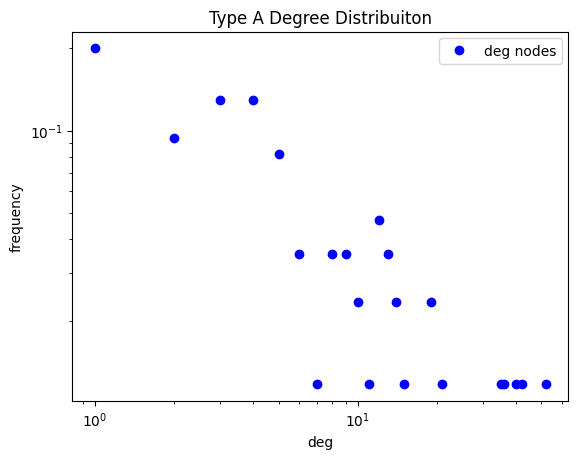

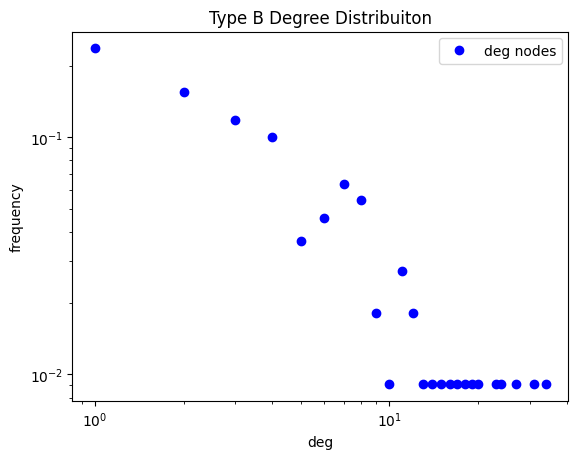

In [25]:
Network_details.plt_deg_distr(deg_typeA, title='Type A', binned=False)
Network_details.plt_deg_distr(deg_typeB, title='Type B', binned=False)

## Main Inference

In [26]:
num_chains = 1 # 1 or 2 chain
num_samples = 5000 # 7000
num_warmup = 200 # 200
thinning = 2 # stable at 2

# set the arguments
args_mcmc={}

args_mcmc['p'] = p
args_mcmc['Z_obs'] = adj_matrix_zeros

# Upper Nodes
args_mcmc['L'] = L_new
args_mcmc['alpha'] = None
args_mcmc['sigma'] = None
args_mcmc['tau'] = ttau
args_mcmc['scores'] = None
args_mcmc['a'] = None
args_mcmc['b'] = None
args_mcmc['wi0'] = None

# Bottom Nodes
args_mcmc['L_prime'] = L_prime_new
args_mcmc['alpha_prime'] = None
args_mcmc['sigma_prime'] = None
args_mcmc['tau_prime'] = ttau_prime
args_mcmc['scores_prime'] = None
args_mcmc['a_prime'] = None
args_mcmc['b_prime'] = None
args_mcmc['wj0'] = None

args_mcmc['samples']={}

args_mcmc['num_chains'] = num_chains
args_mcmc['num_samples'] = num_samples
args_mcmc['thinning'] = thinning

In [27]:
infer = Infer_Bipartite_Network(infer_args=args_mcmc)
infer.infer_network()

[('p', 3), ('Z_obs', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])), ('L', 270), ('alpha', None), ('sigma', None), ('tau', 1.0), ('scores', None), ('a', None), ('b', None), ('wi0', None), ('L_prime', 180), ('alpha_prime', None), ('sigma_prime', None), ('tau_prime', 1.0), ('scores_prime', None), ('a_prime', None), ('b_prime', None), ('wj0', None), ('samples', {}), ('num_chains', 1), ('num_samples', 5000), ('thinning', 2)]
Upper hyperparameters:
 tau:1.0, sigma:0.4340122640132904, alpha:0.7668227553367615, a:[0.31073564 0.6023828  1.7937478 ], b:[0.31073564 0.6023828  1.7937478 ]
Bottom hyperparameters:
 tau:1.0, sigma:0.4340122640132904, alpha:0.7668227553367615, a:[0.31073564 0.6023828  1.7937478 ], b:[0.31073564 0.6023828  1.7937478 ]
Scores: (270, 3) Wi0:(270,)
Scores_prieme:(180, 3) Wj0:(180

  0%|          | 0/5100 [00:00<?, ?it/s]

Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7d40d841c810>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x7d40d843e480; to 'JaxprTracer' at 0x7d40d843e430>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul a b
    e:f32[] = mul d c
  in (e,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (Fals

sample: 100%|██████████| 5100/5100 [50:41<00:00,  1.68it/s, 59 steps of size 4.95e-02. acc. prob=0.83] 


Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>
Bottom hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>
Scores: (270, 3) Wi0:(270,)
Scores_prieme:(180, 3) Wj0:(180,)

                         mean       std    median      5.0%     95.0%     n_eff     r_hat
               a[0]      1.67      1.08      1.44      0.18      3.14     40.01      1.01
               a[1]      0.99      0.95      0.59      0.13      2.36     13.92      1.22
               a[2]      1.42      1.0

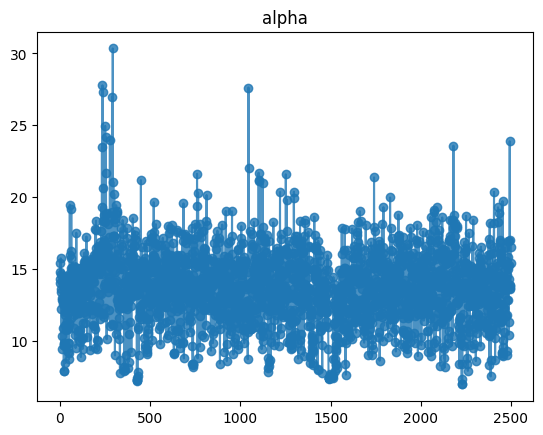

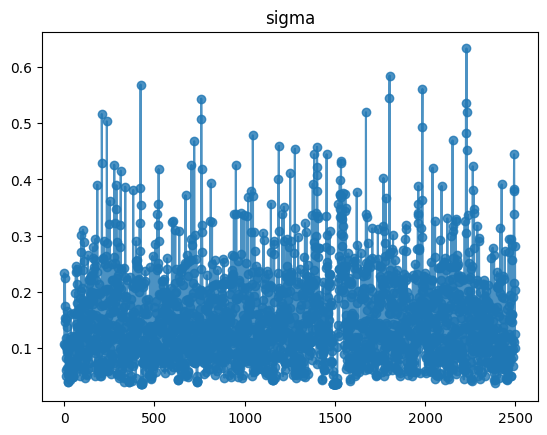

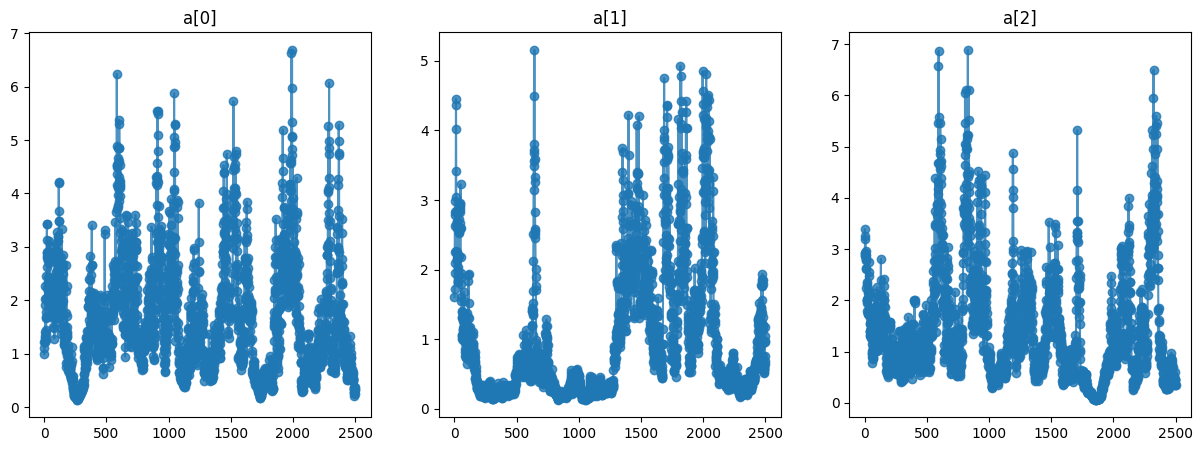

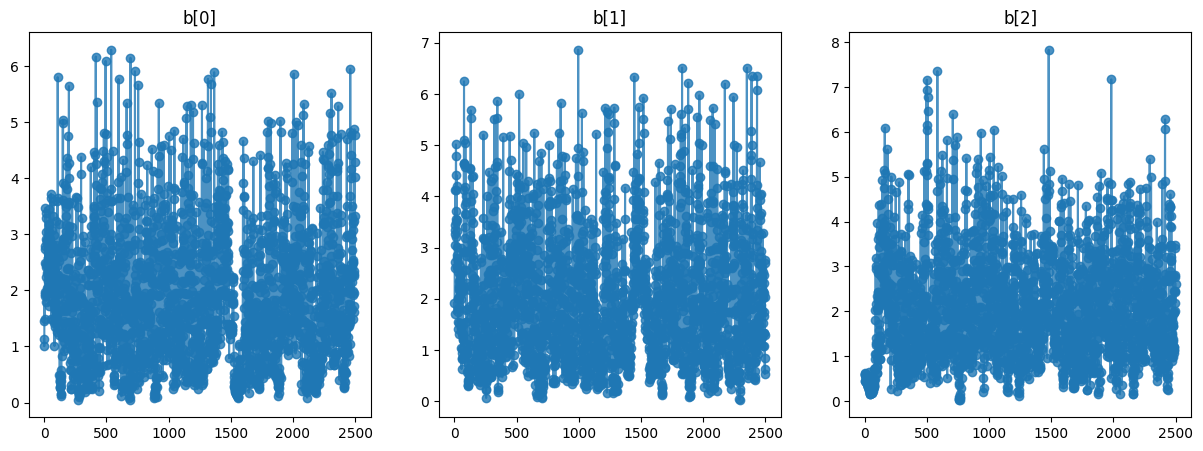

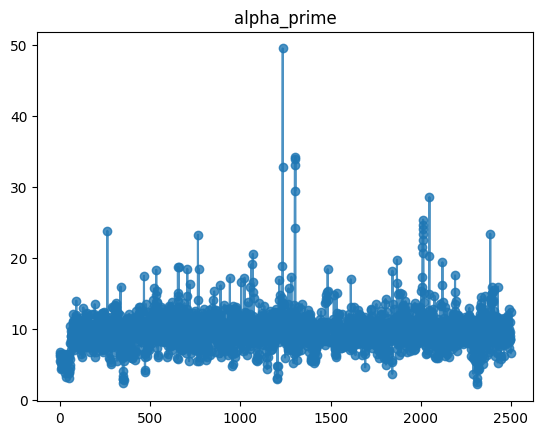

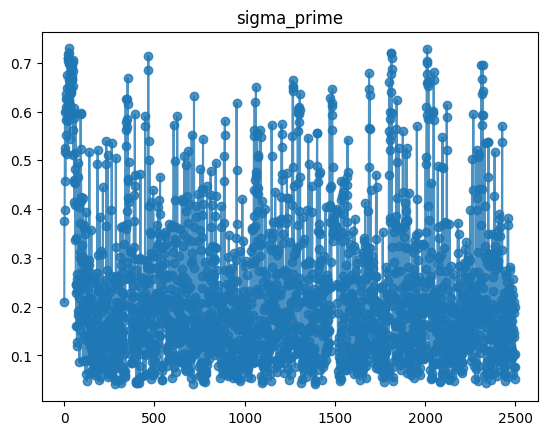

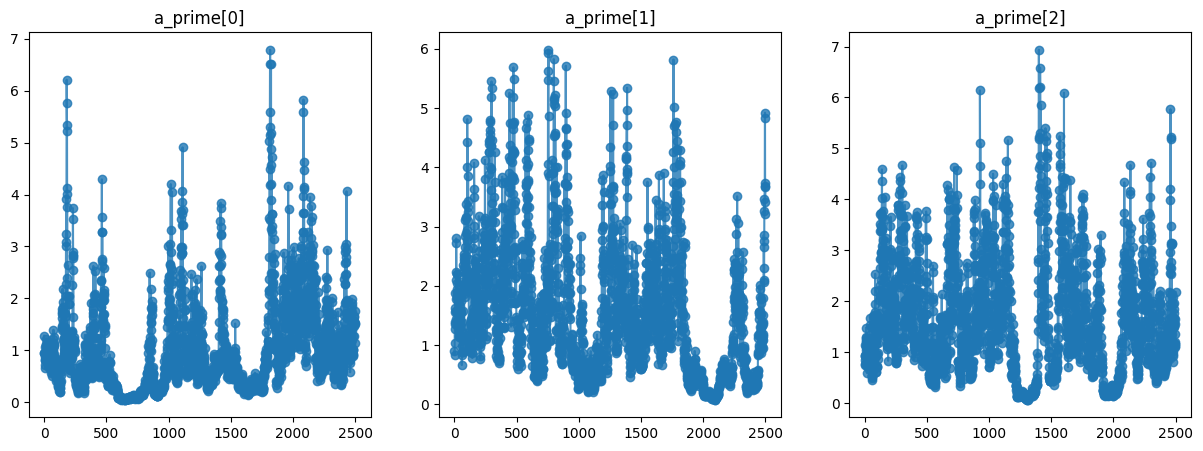

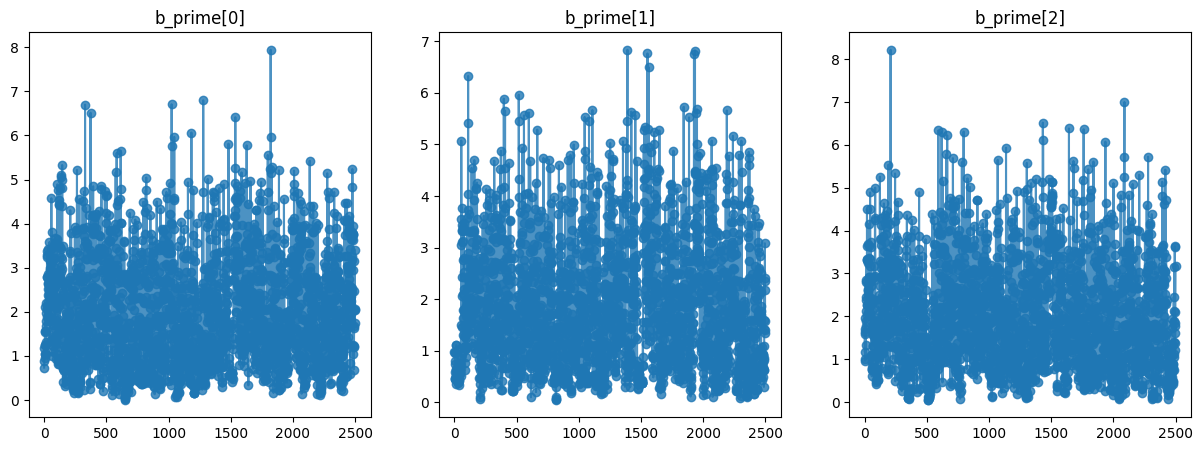

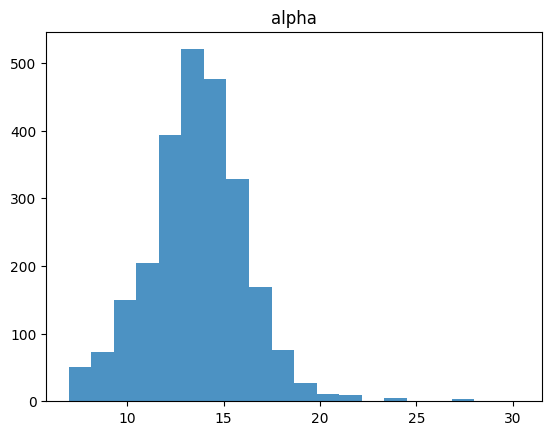

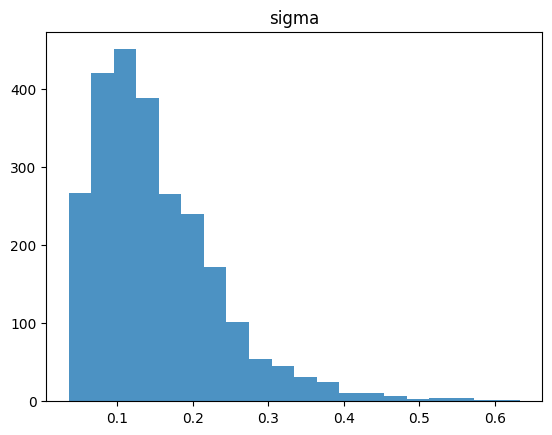

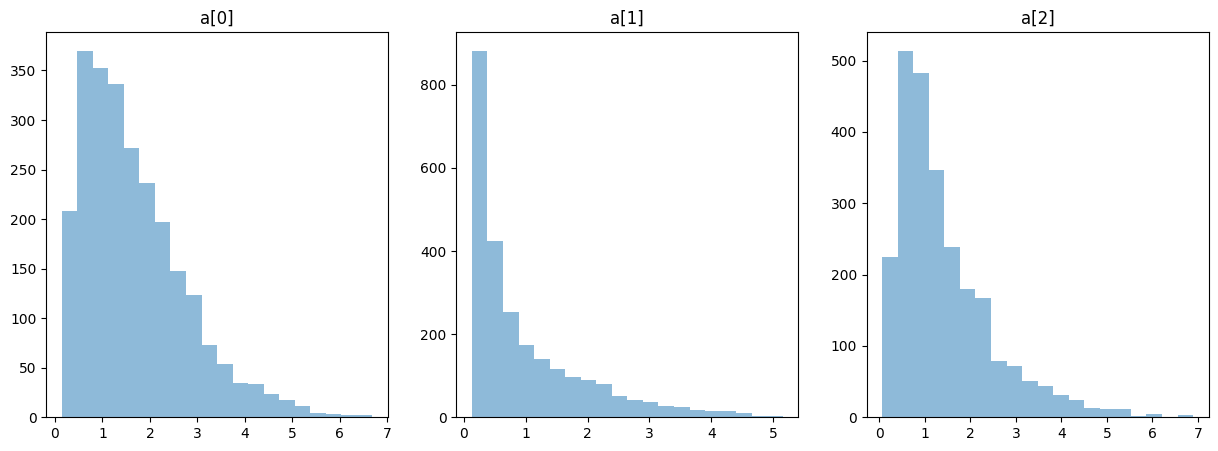

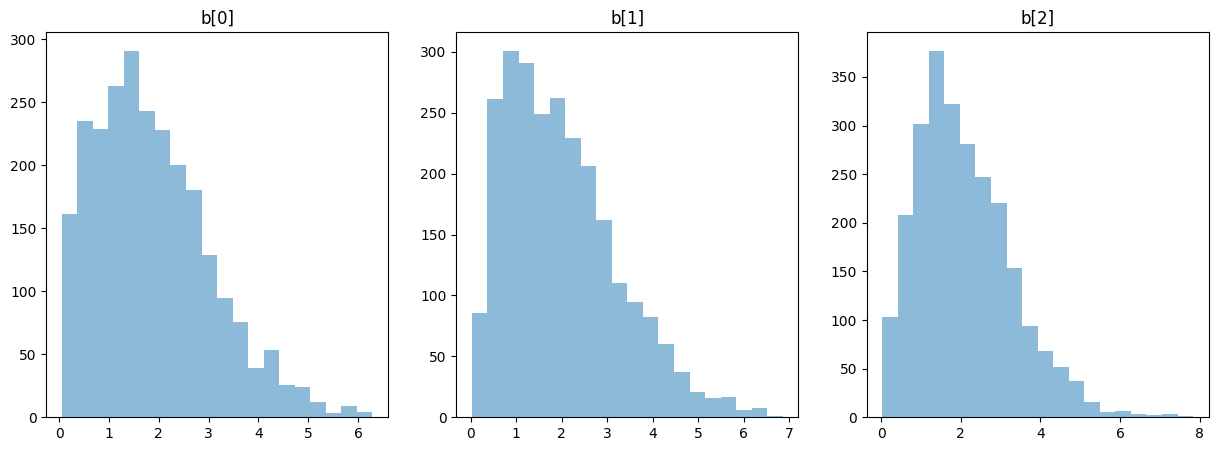

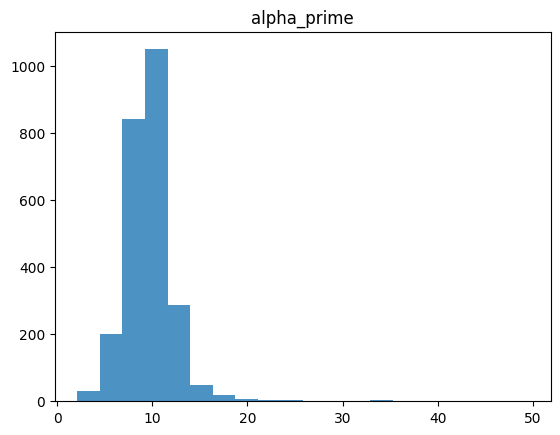

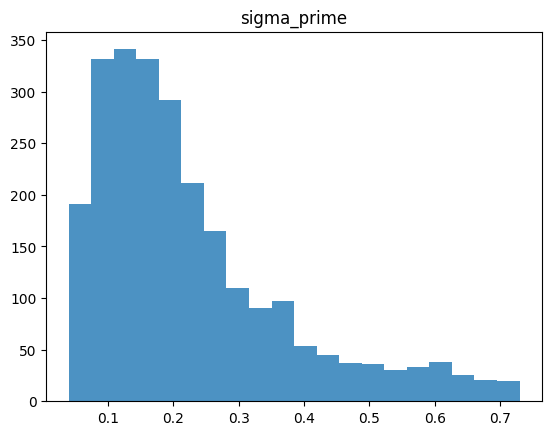

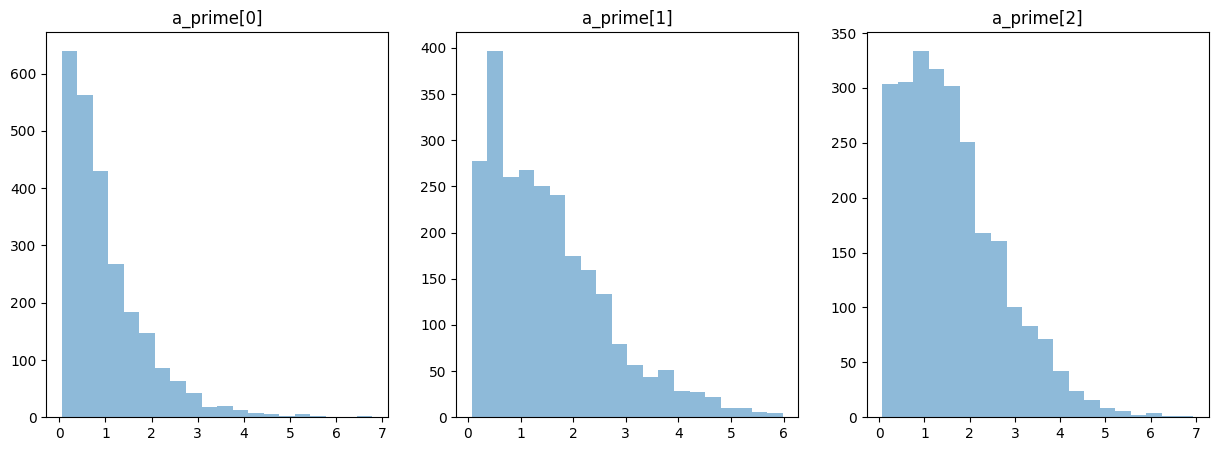

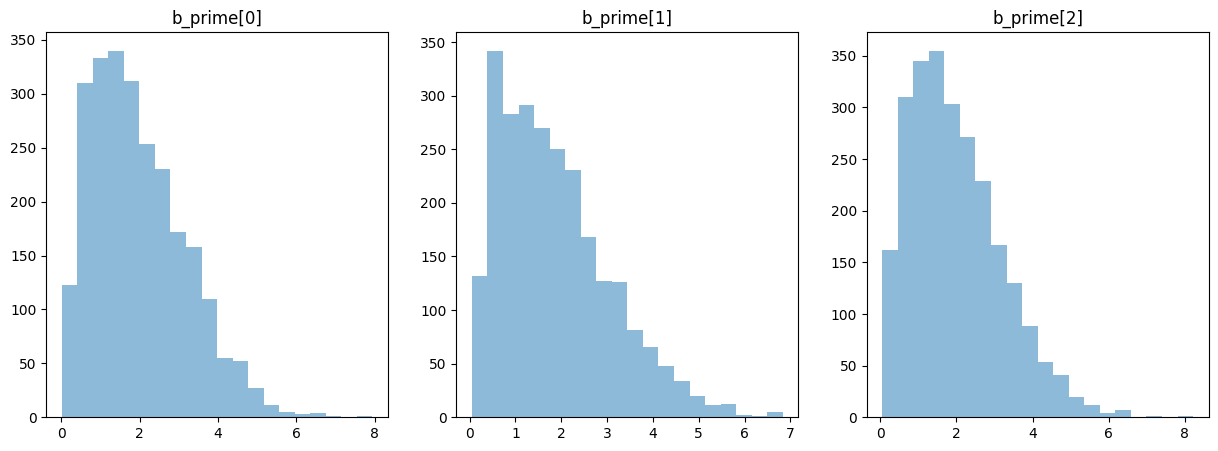

In [28]:
samples = infer.get_samples()
infer.Plot_Traces()
infer.Plot_Histograms()

Wi0 Shape:(2, 270)
Wj0 Shape:(2, 180)


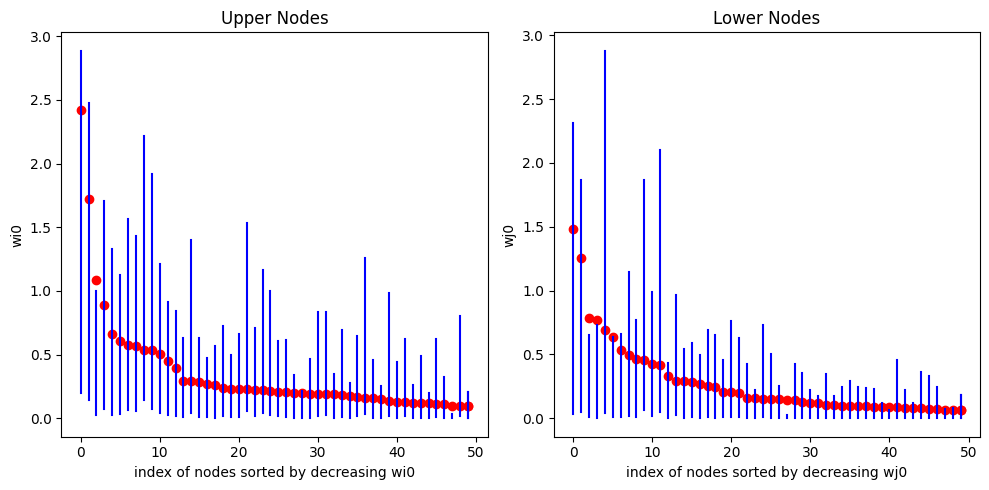

In [29]:
Posterior_distribution(samples_vals=samples,
                       original_val=graph_draws,
                       num_samples=args_mcmc['num_samples'],
                       thinning=args_mcmc['thinning'],
                       num_chains=args_mcmc['num_chains'],
                       L=L_new, L_prime=L_prime_new)

In [ ]:
# Posterior_distribution_Log(samples_vals=samples,
#                        original_val=graph_draws,
#                        num_samples=args_mcmc['num_samples'],
#                        thinning=args_mcmc['thinning'],
#                        num_chains=args_mcmc['num_chains'],
#                        L=L_new, L_prime=L_prime_new)

No Weights 


<ipython-input-16-6761a624a093>:14: UserWarning: Explicitly requested dtype float requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  wi0 = jnp.zeros((L, 1), dtype='float')


(270,)
(180,)
(270, 3)
(180, 3)
(270, 3)
(180, 3)
Wi0:(270,), Wj0:(180,), scores:(270, 3), scores_prime:(180, 3), weights_prime:(180, 3), weights:(270, 3)
N_obs:(270, 180)
Z_obs:(270, 180)
plot_figure Upper
plot_figure Lower


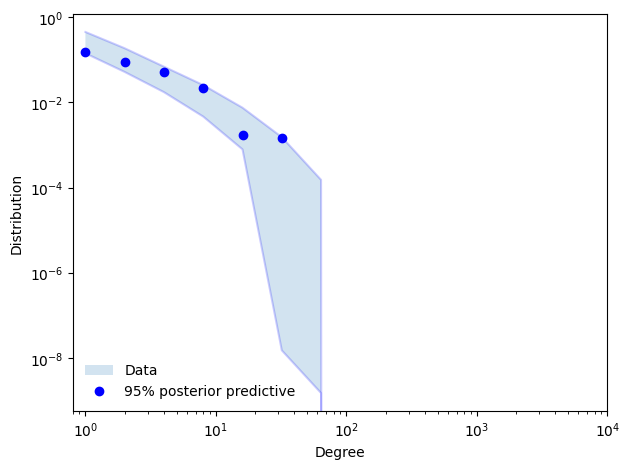

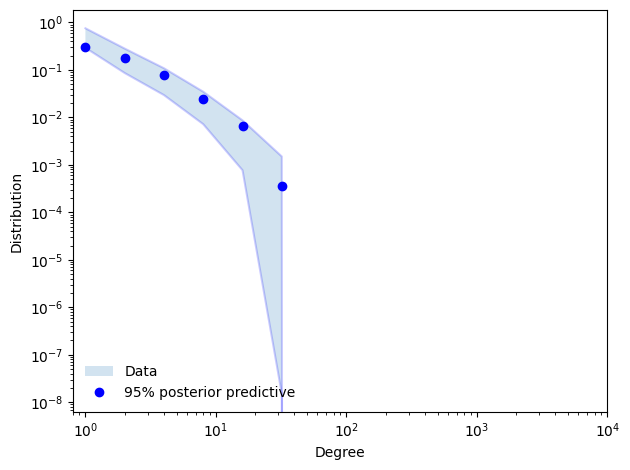

In [31]:
num_draws=500 # change to 500
_, _, _, _, _, _, _, _, _, _ = plot_post_degree_distribution(num_draws = num_draws,
                                                             samples = samples,
                                                             args_dict=args_mcmc,
                                                             original_adj_matrix = adj_matrix_zeros,
                                                             use_weights=0)

# Main Congress Dataset

In [32]:
mat = scipy.io.loadmat('/content/drive/MyDrive/UCY Data /Copy of 112thUSCongressHouse.mat')

In [35]:
adj_mtrx_1, adj_mtrx_2 = mat['votes'][0][0], mat['votes'][0][1]
merged_matrix = np.concatenate((adj_mtrx_1, adj_mtrx_2), axis=1)
print(f'Adj Matrix 1: {adj_mtrx_1.shape}\nAdj Matrix 2:{adj_mtrx_2.shape}\nMerge Matrix:{merged_matrix.shape}')
congress_adj_matrix = np.nan_to_num(merged_matrix, nan=0)

Adj Matrix 1: (451, 483)
Adj Matrix 2:(451, 326)
Merge Matrix:(451, 809)


**Plots the Adj Matrix**

In [37]:
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.imshow(congress_adj_matrix, cmap='hot', vmax=1)
# plt.show()

In [38]:
def check_zero_rows_columns(adj_matrix):
    # Identify rows and columns that are all zeros
    zero_rows = np.where(np.all(adj_matrix == 0, axis=1))[0]
    zero_cols = np.where(np.all(adj_matrix == 0, axis=0))[0]
    return zero_rows, zero_cols

In [39]:
zero_rows, zero_cols = check_zero_rows_columns(adj_matrix)
print("Rows with all zeros:", zero_rows if zero_rows.size > 0 else "None")
print("Columns with all zeros:", zero_cols if zero_cols.size > 0 else "None")

Rows with all zeros: [ 33  54  58 100 122 129 295 298 326 332 396]
Columns with all zeros: [  0   6 483 625]


In [40]:
congress_adj_matrix_zeros = Network_details.add_zeros(congress_adj_matrix)

zero_rows, zero_cols = check_zero_rows_columns(adj_matrix)
print("Rows with all zeros:", zero_rows if zero_rows.size > 0 else "None")
print("Columns with all zeros:", zero_cols if zero_cols.size > 0 else "None")

Adj matrix: (451, 809) 
New Adj matrix: (496, 889) 
Rows with all zeros: [ 33  54  58 100 122 129 295 298 326 332 396]
Columns with all zeros: [  0   6 483 625]


(496, 889)

In [54]:
p = 4 # number of comunities (not inferred)
L_congress, L_congress_prime = congress_adj_matrix_zeros[0].shape[0], congress_adj_matrix_zeros[0].shape[1] # number of upper & bottom nodes (not inferred)
ttau, ttau_prime = 1, 1
num_chains = 1 # 1 or 2 chain
num_samples = 3000
num_warmup = 100
thinning = 2 # stable at 2

In [55]:
# set the arguments
args_congress={}

args_congress['p'] = p
args_congress['Z_obs'] = congress_adj_matrix_zeros

# Upper Nodes
args_congress['L'] = L_congress
args_congress['alpha'] = None
args_congress['sigma'] = None
args_congress['tau'] = ttau
args_congress['scores'] = None
args_congress['a'] = None
args_congress['b'] = None
args_congress['wi0'] = None

# Bottom Nodes
args_congress['L_prime'] = L_congress_prime
args_congress['alpha_prime'] = None
args_congress['sigma_prime'] = None
args_congress['tau_prime'] = ttau_prime
args_congress['scores_prime'] = None
args_congress['a_prime'] = None
args_congress['b_prime'] = None
args_congress['wj0'] = None

args_congress['samples']={}

args_congress['num_chains'] = num_chains
args_congress['num_samples'] = num_samples
args_congress['thinning'] = thinning

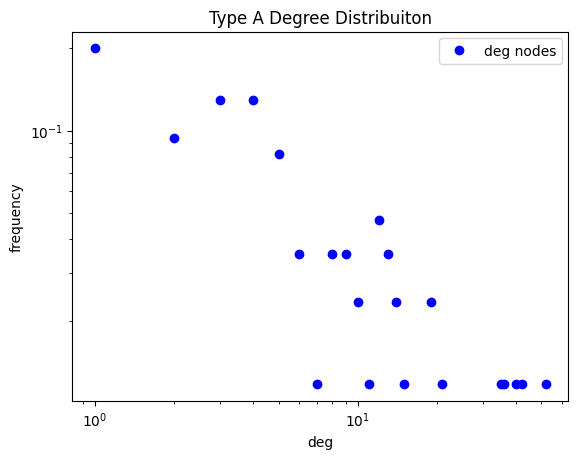

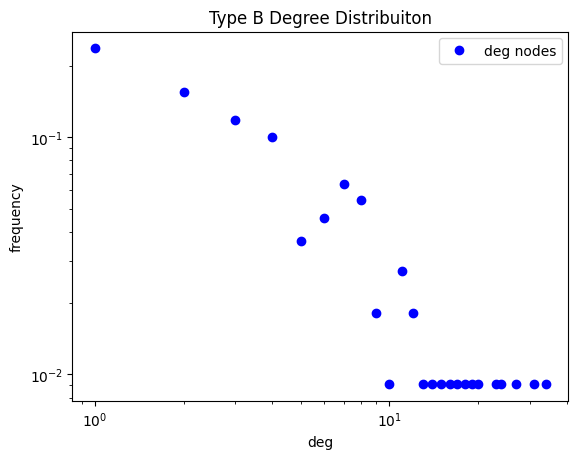

In [56]:
type_A_deg = congress_adj_matrix_zeros[0].sum(axis=1)
type_B_deg = congress_adj_matrix_zeros[0].sum(axis=0)
Network_details.plt_deg_distr(deg_typeA, title='Type A', binned=False)
Network_details.plt_deg_distr(deg_typeB, title='Type B', binned=False)

In [57]:
Network_details.network_statistics(typeA_nodes=L_congress,
                                   typeB_nodes=L_congress_prime,
                                   adj_matrix=congress_adj_matrix_zeros[0])

+-----------------------+-------------+
| Metric                |       Value |
+=======================+=============+
| # Top Nodes           |    889      |
+-----------------------+-------------+
| # Bottom Nodes        |    496      |
+-----------------------+-------------+
| # Edges               | 183010      |
+-----------------------+-------------+
| Top average degree    |    368.972  |
+-----------------------+-------------+
| Bottom Average degree |    205.861  |
+-----------------------+-------------+
| Graph Average degree  |    636.742  |
+-----------------------+-------------+
| Density               |      0.415  |
+-----------------------+-------------+
| Sparsity              |      0.0954 |
+-----------------------+-------------+
